# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [178]:
# Load the libraries as required.

%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))


# Data manipulation 
import pandas as pd
import numpy as np

# Modeling and Preprocessing 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Model Explanation
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# For saving the model
import pickle

# Set random seed for reproducibility
np.random.seed(42)


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [179]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Initial data exploration 

In [180]:
# Initial data exploration 

print("Dataset shape:", fires_dt.shape)
print("\nDataset info:")
fires_dt.info()

Dataset shape: (517, 13)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [181]:
# Basic statistics and distribution of numerical vairables 
print("\n Numerical Features statistics: ")
display(fires_dt.describe())


 Numerical Features statistics: 


,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [182]:
# Check the distribution of the target variable
print("\nTarget Variable (area) Statistics:")
print("Zero areas:", (fires_dt['area'] ==0).sum())
print("Mean area:", fires_dt['area'].mean())
print("Median area:", fires_dt['area'].median())
print("Max area:", fires_dt['area'].max())


Target Variable (area) Statistics:
Zero areas: 247
Mean area: 12.847292069632493
Median area: 0.52
Max area: 1090.84


In [183]:
# Check categorical variables 
print("\nCategorical Variables Unique Values:")
print("\nMonth distribution:")
display(fires_dt['month'].value_counts())
print("\nDay distribution:")
display(fires_dt['day'].value_counts())


Categorical Variables Unique Values:

Month distribution:


month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64


Day distribution:


day
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: count, dtype: int64

In [184]:
# Define feature groups for preprocessing 

categorical_features = ['month', 'day']

numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain',]

target = ['area']

In [185]:
# Check for missing values 

missing_values = fires_dt.isnull().sum()

if missing_values.sum() > 0: 
    print("\nMissing Values:")
    display(missing_values[missing_values>0])
else:
    print("\n No missing values in the dataset")



 No missing values in the dataset


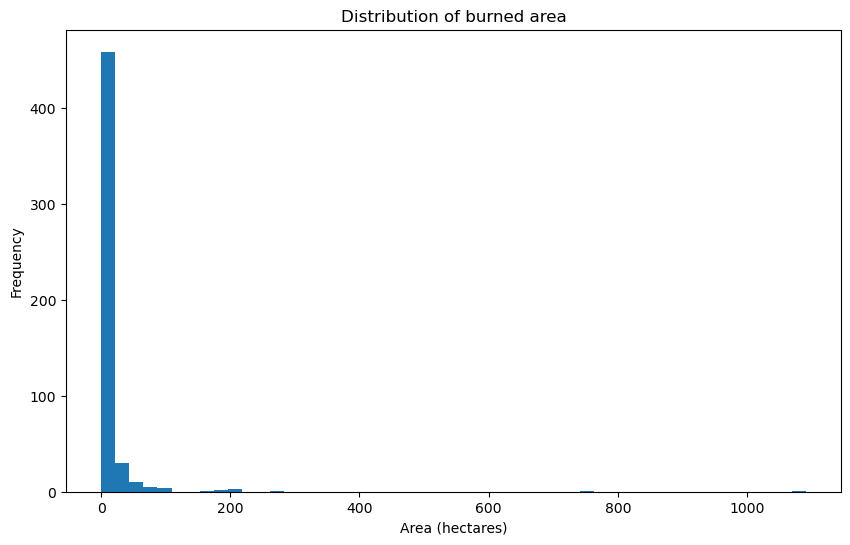

In [186]:
# Looking for correlation between numerical features 

plt.figure(figsize=(10,6))
plt.hist(fires_dt['area'], bins = 50)
plt.title('Distribution of burned area')
plt.xlabel('Area (hectares)')
plt.ylabel('Frequency')
plt.show()

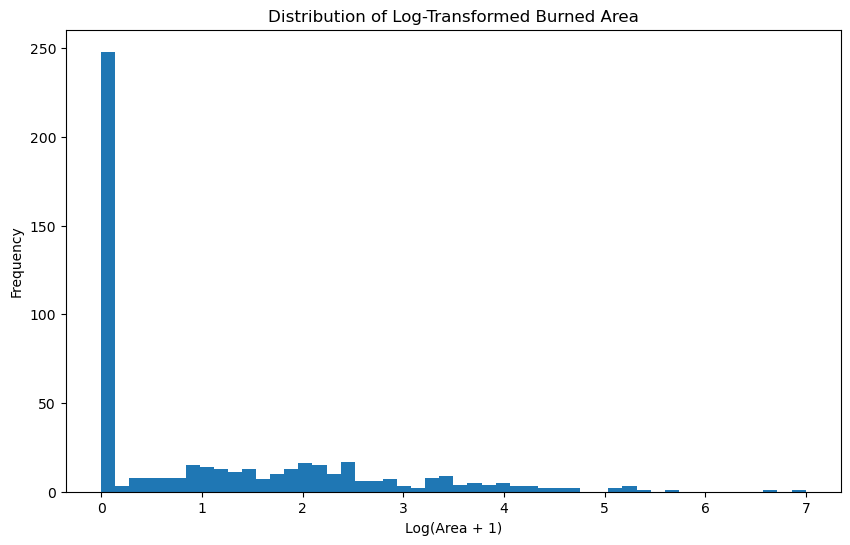

In [187]:
# Showing log distribution since the area might be right-skewed 

plt.figure(figsize=(10,6))
plt.hist(np.log1p(fires_dt['area']), bins=50)
plt.title('Distribution of Log-Transformed Burned Area')
plt.xlabel('Log(Area + 1)')
plt.ylabel('Frequency')
plt.show()

# Get X and Y

Create the features data frame and target data.

In [188]:
X = fires_dt.drop(columns= 'area') # Features 
Y = fires_dt['area'] #Target data 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) 

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [189]:
# Creating the Preprocessing 1 pipeline 

preproc1 = ColumnTransformer( 
    transformers=[
        # Numeric transformation : scaling 
        ('numeric', StandardScaler(), numerical_features), 

        # Categorical transformation: One hot encoding 
        ('categorical', OneHotEncoder(drop='first', sparse_output= False, handle_unknown='ignore'), categorical_features)
    ], remainder='drop'
)

preproc1

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('categorical',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['month', 'day'])])

In [190]:
# # Verifying that the preprocessor works 

# Fit and transform on training data
X_train_transformed = preproc1.fit_transform(X_train)

# Transform test data (only transform, no fitting)
X_test_transformed = preproc1.transform(X_test)

# Verify the shapes
print("Original training data shape:", X_train.shape)
print("Transformed training data shape:", X_train_transformed.shape)

# Get feature names after transformation (useful for later analysis)
numeric_features_out = numerical_features
categorical_features_out = preproc1.named_transformers_['categorical'].get_feature_names_out(categorical_features)
all_features_out = np.concatenate([numeric_features_out, categorical_features_out])

# Create a sample DataFrame with transformed data to verify
print("\nSample of transformed data:")
transformed_df = pd.DataFrame(
    X_train_transformed[:5],  # First 5 rows
    columns=all_features_out
)
print(transformed_df.head())

# Verify scaling worked correctly on numeric features
print("\nNumeric features statistics after scaling:")
numeric_stats = transformed_df[numerical_features].describe()
print(numeric_stats)

Original training data shape: (361, 12)
Transformed training data shape: (361, 27)

Sample of transformed data:
    coord_x   coord_y      ffmc       dmc        dc       isi      temp  \
0  0.554924 -1.115595  0.312274 -0.095595  0.847765  0.294384  1.030827   
1  0.554924  0.541729  0.109277 -0.269949  0.793017 -0.089641 -0.358231   
2  0.992320 -0.286933 -0.059887 -0.018273 -0.034196 -0.652879  0.110576   
3  1.429716  1.370391  0.261525  0.613948  0.448545  1.420860  0.214756   
4  0.554924  0.541729 -6.285127 -0.623204 -1.247441 -2.137779 -1.434751   

         rh      wind      rain  ...  month_may  month_nov  month_oct  \
0 -1.012582 -1.217840 -0.070974  ...        0.0        0.0        0.0   
1  0.136351  0.524534 -0.070974  ...        0.0        0.0        0.0   
2 -0.105530  1.030384 -0.070974  ...        0.0        0.0        0.0   
3  0.801523  0.299711 -0.070974  ...        0.0        0.0        0.0   
4  2.736567 -0.711990 -0.070974  ...        0.0        0.0        0.0   

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [191]:
# Separating features that will need log transformation 

log_features = ['dmc', 'dc', 'isi']
regular_numeric = [feat for feat in numerical_features if feat not in log_features]

#Create preproc 2 with non-linear transformations 

preproc2 = ColumnTransformer(
    transformers=[
        # Regular numeric features to be scaled 
        ('regular_numeric', StandardScaler(), regular_numeric), 

        # Skewed numeric features: log transform and scale
        ('log_numeric', Pipeline([
            ('log', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), log_features), 

        #Categorical features: One Hot Encoding 
        ('categorical', OneHotEncoder(drop='first', sparse_output= False, handle_unknown='ignore'), 
        categorical_features)
        ],
        remainder='drop' 
    )
preproc2

ColumnTransformer(transformers=[('regular_numeric', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'temp', 'rh',
                                  'wind', 'rain']),
                                ('log_numeric',
                                 Pipeline(steps=[('log', PowerTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['dmc', 'dc', 'isi']),
                                ('categorical',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['month', 'day'])])


Sample of transformed data with preproc2:
    coord_x   coord_y      ffmc      temp        rh      wind      rain  \
0  0.554924 -1.115595  0.312274  1.030827 -1.012582 -1.217840 -0.070974   
1  0.554924  0.541729  0.109277 -0.358231  0.136351  0.524534 -0.070974   
2  0.992320 -0.286933 -0.059887  0.110576 -0.105530  1.030384 -0.070974   
3  1.429716  1.370391  0.261525  0.214756  0.801523  0.299711 -0.070974   
4  0.554924  0.541729 -6.285127 -1.434751  2.736567 -0.711990 -0.070974   

        dmc        dc       isi  ...  month_may  month_nov  month_oct  \
0  0.033270  0.919867  0.359902  ...        0.0        0.0        0.0   
1 -0.141006  0.848153 -0.014329  ...        0.0        0.0        0.0   
2  0.108201 -0.166312 -0.604961  ...        0.0        0.0        0.0   
3  0.677596  0.409490  1.363317  ...        0.0        0.0        0.0   
4 -0.521607 -1.369165 -2.665459  ...        0.0        0.0        0.0   

   month_sep  day_mon  day_sat  day_sun  day_thu  day_tue  day_wed 

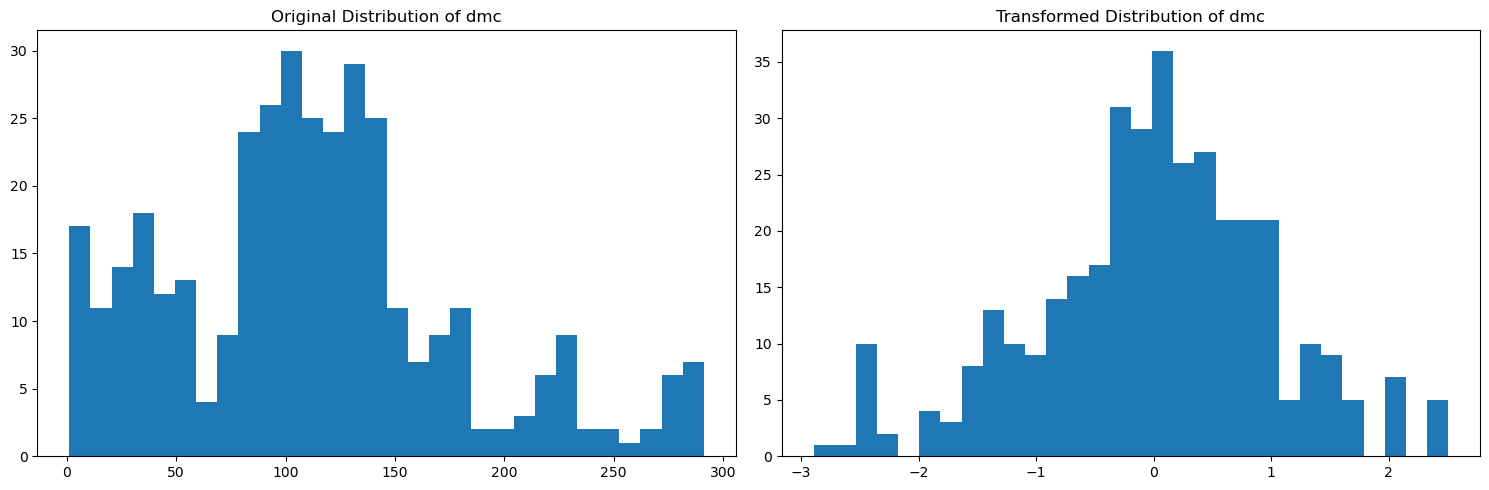


Basic statistics of transformed numerical features:
        coord_x   coord_y      ffmc       dmc        dc       isi      temp  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.817361  0.210264 -1.132388  0.031291  0.128407 -0.312306 -0.087364   
std    0.391219  0.944820  2.884127  0.435606  0.942474  1.497610  0.904106   
min    0.554924 -1.115595 -6.285127 -0.521607 -1.369165 -2.665459 -1.434751   
25%    0.554924 -0.286933 -0.059887 -0.141006 -0.166312 -0.604961 -0.358231   
50%    0.554924  0.541729  0.109277  0.033270  0.409490 -0.014329  0.110576   
75%    0.992320  0.541729  0.261525  0.108201  0.848153  0.359902  0.214756   
max    1.429716  1.370391  0.312274  0.677596  0.919867  1.363317  1.030827   

             rh      wind      rain  
count  5.000000  5.000000  5.000000  
mean   0.511266 -0.015040 -0.070974  
std    1.403507  0.924065  0.000000  
min   -1.012582 -1.217840 -0.070974  
25%   -0.105530 -0.711990 -0.070974  
50%    

In [192]:
# Apply transformations
X_train_transformed2 = preproc2.fit_transform(X_train)
X_test_transformed2 = preproc2.transform(X_test)

# Get feature names
regular_features_out = regular_numeric
log_features_out = log_features
categorical_features_out = preproc2.named_transformers_['categorical'].get_feature_names_out(categorical_features)
all_features_out2 = np.concatenate([regular_features_out, log_features_out, categorical_features_out])

# Create DataFrame to verify transformations
print("\nSample of transformed data with preproc2:")
transformed_df2 = pd.DataFrame(
    X_train_transformed2[:5],
    columns=all_features_out2
)
print(transformed_df2.head())

# Compare distributions before and after transformation for a log-transformed feature
plt.figure(figsize=(15, 5))

# Original distribution of a log-transformed feature
plt.subplot(1, 2, 1)
plt.hist(X_train[log_features[0]], bins=30)
plt.title(f'Original Distribution of {log_features[0]}')

# Transformed distribution
plt.subplot(1, 2, 2)
plt.hist(X_train_transformed2[:, numerical_features.index(log_features[0])], bins=30)
plt.title(f'Transformed Distribution of {log_features[0]}')

plt.tight_layout()
plt.show()

# Print basic statistics of transformed data
print("\nBasic statistics of transformed numerical features:")
print(transformed_df2[numerical_features].describe())

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [193]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_squared_error as mse 
import numpy as np

In [194]:
# Create a RMSE scorer 

rmse_scorer = make_scorer (
    lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
)


In [195]:
# Pipeline A = preproc1 + baseline

baseline_pipe1 = Pipeline([
    ('preprocessing', preproc1), 
    ('regressor', Ridge())
])

baseline_pipe1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [196]:
# Pipeline B = preproc2 + baseline

baseline_pipe2 = Pipeline([
    ('preprocessing', preproc2), 
    ('regressor', Ridge())
])

baseline_pipe2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('regular_numeric',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('log_numeric',
                                                  Pipeline(steps=[('log',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc', 'isi']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [197]:
# Advanced model (Random Forest) with both preprocessors

# Pipeline C = preproc1 + advanced model

advanced_pipe1 = Pipeline([
    ('preprocessing', preproc1), 
    ('regressor', RandomForestRegressor(random_state=42))
])

advanced_pipe1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [198]:
# Pipeline D = preproc2 + advanced model

advanced_pipe2 = Pipeline([
    ('preprocessing', preproc2), 
    ('regressor', RandomForestRegressor(random_state=42))

])
advanced_pipe2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('regular_numeric',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('log_numeric',
                                                  Pipeline(steps=[('log',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc', 'isi']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [199]:
# Let's check all our data shapes
print("Original data shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {Y.shape}")

# Check if shapes match in train-test split
print("\nTrain-test split shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {Y_test.shape}")

Original data shapes:
X shape: (517, 12)
y shape: (517,)

Train-test split shapes:
X_train shape: (361, 12)
y_train shape: (361,)
X_test shape: (156, 12)
y_test shape: (156,)


In [200]:
# Grid search parameters for Ridge 

baseline_param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

# Grid search parameters for Random Forest 

advanced_param_grid = {
    'regressor__n_estimators': [100,200], 
    'regressor__max_depth': [10,20,], 
    'regressor__min_samples_split': [2,5]
}

### Performing Grid search on the pipelines

#### Pipeline 1:

In [201]:
grid_cv_pipe1 = GridSearchCV(
    estimator=baseline_pipe1, 
    param_grid=baseline_param_grid,
    scoring=rmse_scorer, 
    cv=5, 
    verbose=1
)

grid_cv_pipe1.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.1, 1.0, 10.0, 100.0]},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [202]:
res1 = grid_cv_pipe1.cv_results_
res1 = pd.DataFrame(res1)
res1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016848,0.009719,0.005544,0.000413,0.1,{'regressor__alpha': 0.1},44.194335,26.247349,31.207577,90.904785,27.345744,43.979958,24.315680,1
1,0.009088,0.000571,0.004480,0.000695,1.0,{'regressor__alpha': 1.0},44.188607,26.237008,31.459637,90.804349,27.138689,43.965658,24.280713,2
2,0.009734,0.001103,0.004654,0.000546,10.0,{'regressor__alpha': 10.0},43.794972,25.967637,30.643154,90.588738,26.336674,43.466235,24.432325,3
3,0.010007,0.000699,0.005266,0.000760,100.0,{'regressor__alpha': 100.0},43.001547,25.263610,26.459281,90.291243,25.270646,42.057265,25.038062,4


In [203]:
grid_cv_pipe1.best_params_

{'regressor__alpha': 0.1}

In [204]:
grid_cv_pipe1.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', Ridge(alpha=0.1))])

#### Pipeline 2


In [205]:
grid_cv_pipe2 = GridSearchCV(
    estimator=baseline_pipe2, 
    param_grid=baseline_param_grid,
    scoring=rmse_scorer, 
    cv=5, 
    verbose=1
)

grid_cv_pipe2.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('regular_numeric',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('log_numeric',
                                                                         Pipeline(steps=[('log',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dmc',
                                                                          'dc',
                                                                          'isi']),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.1, 1.0, 10.0, 100.0]},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [206]:
res2 = grid_cv_pipe2.cv_results_
res2 = pd.DataFrame(res2)
res2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022080,0.002208,0.006799,0.001019,0.1,{'regressor__alpha': 0.1},43.840265,26.111717,31.394669,90.829537,27.371064,43.909450,24.283314,1
1,0.019130,0.002124,0.007347,0.001637,1.0,{'regressor__alpha': 1.0},43.819844,26.033733,31.397785,90.741084,27.075709,43.813631,24.300708,2
2,0.018914,0.001919,0.008634,0.004531,10.0,{'regressor__alpha': 10.0},43.490959,25.900034,30.392850,90.593651,26.202927,43.316084,24.488315,3
3,0.018250,0.003626,0.006568,0.000985,100.0,{'regressor__alpha': 100.0},42.870032,25.321839,26.269326,90.309494,25.250855,42.004309,25.062774,4


In [207]:
grid_cv_pipe2.best_params_

{'regressor__alpha': 0.1}

In [208]:
grid_cv_pipe2.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('regular_numeric',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('log_numeric',
                                                  Pipeline(steps=[('log',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc', 'isi']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', Ridge(alpha=0.1))])

#### Pipeline 3


In [209]:
grid_cv_pipe3 = GridSearchCV(
    estimator=advanced_pipe1, 
    param_grid=advanced_param_grid,
    scoring=rmse_scorer, 
    cv=5, 
    verbose=1
)

grid_cv_pipe3.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [210]:
res3 = grid_cv_pipe3.cv_results_
res3 = pd.DataFrame(res3)
res3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__min_samples_split,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.400422,0.093350,0.017418,0.003049,10,2,100,"{'regressor__max_depth': 10, 'regressor__min_s...",59.142248,35.915983,35.919436,93.114728,28.727311,50.563941,23.622106,1
1,0.660887,0.084558,0.021471,0.002520,10,2,200,"{'regressor__max_depth': 10, 'regressor__min_s...",57.190247,34.981390,34.752548,93.594362,28.897788,49.883267,23.897476,3
2,0.283678,0.015824,0.011653,0.001391,10,5,100,"{'regressor__max_depth': 10, 'regressor__min_s...",58.028880,30.187147,33.720426,93.261774,29.749042,48.989454,24.489234,5
3,0.605517,0.074922,0.019408,0.002029,10,5,200,"{'regressor__max_depth': 10, 'regressor__min_s...",56.263105,29.928047,32.765262,93.470647,29.523652,48.390143,24.638043,7
4,0.325996,0.032223,0.010992,0.000168,20,2,100,"{'regressor__max_depth': 20, 'regressor__min_s...",58.469054,35.662878,34.671968,93.104854,29.059902,50.193731,23.700443,2
5,0.652317,0.052472,0.017778,0.001157,20,2,200,"{'regressor__max_depth': 20, 'regressor__min_s...",57.625893,34.452945,34.487305,93.562021,28.800724,49.785778,24.030557,4
6,0.292378,0.005140,0.010959,0.000527,20,5,100,"{'regressor__max_depth': 20, 'regressor__min_s...",56.914201,30.190649,33.238030,93.306617,29.523725,48.634645,24.521828,6
7,0.591341,0.014449,0.017899,0.000956,20,5,200,"{'regressor__max_depth': 20, 'regressor__min_s...",55.465955,29.858096,33.022926,93.515701,28.945895,48.161715,24.673018,8


In [211]:
grid_cv_pipe3.best_params_

{'regressor__max_depth': 10,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [212]:
grid_cv_pipe3.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, random_state=42))])

#### Pipeline 4


In [213]:
grid_cv_pipe4 = GridSearchCV(
    estimator=advanced_pipe2, 
    param_grid=advanced_param_grid,
    scoring=rmse_scorer, 
    cv=5, 
    verbose=1
)

grid_cv_pipe4.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('regular_numeric',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('log_numeric',
                                                                         Pipeline(steps=[('log',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dmc',
                                                                          'dc',
                                                                          'isi']),
                                                                        ('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring=make_scorer(<lambda>, response_method='predict'),
             verbose=1)

In [214]:
res4 = grid_cv_pipe4.cv_results_
res4 = pd.DataFrame(res3)
res4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__min_samples_split,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.400422,0.093350,0.017418,0.003049,10,2,100,"{'regressor__max_depth': 10, 'regressor__min_s...",59.142248,35.915983,35.919436,93.114728,28.727311,50.563941,23.622106,1
1,0.660887,0.084558,0.021471,0.002520,10,2,200,"{'regressor__max_depth': 10, 'regressor__min_s...",57.190247,34.981390,34.752548,93.594362,28.897788,49.883267,23.897476,3
2,0.283678,0.015824,0.011653,0.001391,10,5,100,"{'regressor__max_depth': 10, 'regressor__min_s...",58.028880,30.187147,33.720426,93.261774,29.749042,48.989454,24.489234,5
3,0.605517,0.074922,0.019408,0.002029,10,5,200,"{'regressor__max_depth': 10, 'regressor__min_s...",56.263105,29.928047,32.765262,93.470647,29.523652,48.390143,24.638043,7
4,0.325996,0.032223,0.010992,0.000168,20,2,100,"{'regressor__max_depth': 20, 'regressor__min_s...",58.469054,35.662878,34.671968,93.104854,29.059902,50.193731,23.700443,2
5,0.652317,0.052472,0.017778,0.001157,20,2,200,"{'regressor__max_depth': 20, 'regressor__min_s...",57.625893,34.452945,34.487305,93.562021,28.800724,49.785778,24.030557,4
6,0.292378,0.005140,0.010959,0.000527,20,5,100,"{'regressor__max_depth': 20, 'regressor__min_s...",56.914201,30.190649,33.238030,93.306617,29.523725,48.634645,24.521828,6
7,0.591341,0.014449,0.017899,0.000956,20,5,200,"{'regressor__max_depth': 20, 'regressor__min_s...",55.465955,29.858096,33.022926,93.515701,28.945895,48.161715,24.673018,8


In [215]:
grid_cv_pipe4.best_params_

{'regressor__max_depth': 20,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [216]:
grid_cv_pipe4.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('regular_numeric',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('log_numeric',
                                                  Pipeline(steps=[('log',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc', 'isi']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, random_state=42))])

#### Storing and comparing the results

Model Comparison:
                          Pipeline  Best RMSE  \
1         Ridge + Advanced Preproc -43.909450   
0           Ridge + Simple Preproc -43.979958   
2    RandomForest + Simple Preproc -50.563941   
3  RandomForest + Advanced Preproc -51.114149   

                                     Best Parameters  
1                          {'regressor__alpha': 0.1}  
0                          {'regressor__alpha': 0.1}  
2  {'regressor__max_depth': 10, 'regressor__min_s...  
3  {'regressor__max_depth': 20, 'regressor__min_s...  

Best performing model: Ridge + Advanced Preproc
Best RMSE: -43.9095


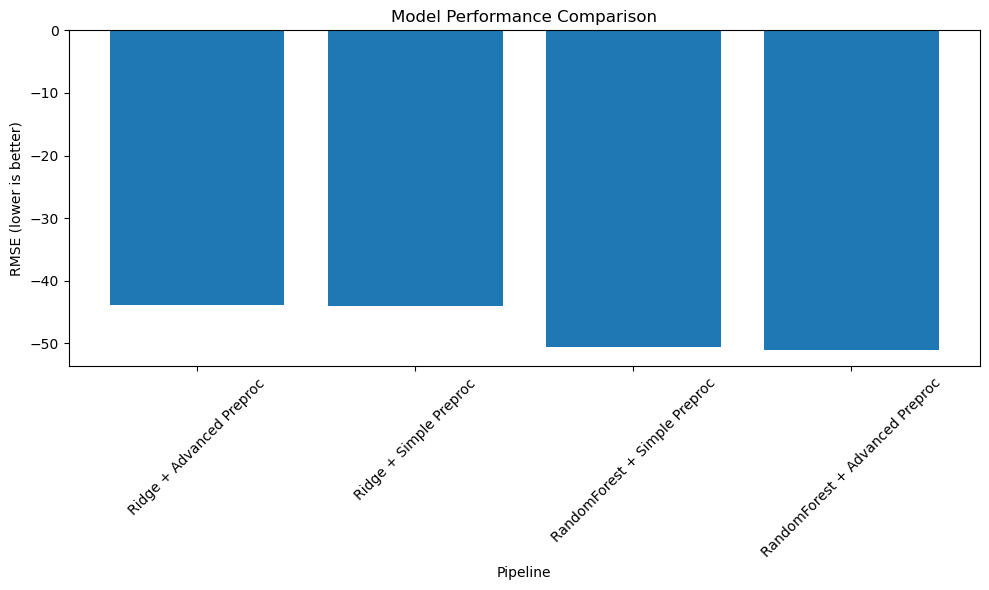

In [217]:
# Step 1: Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Pipeline': ['Ridge + Simple Preproc', 
                'Ridge + Advanced Preproc',
                'RandomForest + Simple Preproc',
                'RandomForest + Advanced Preproc'],
    'Best RMSE': [-grid_cv_pipe1.best_score_,
                  -grid_cv_pipe2.best_score_,
                  -grid_cv_pipe3.best_score_,
                  -grid_cv_pipe4.best_score_],
    'Best Parameters': [grid_cv_pipe1.best_params_,
                       grid_cv_pipe2.best_params_,
                       grid_cv_pipe3.best_params_,
                       grid_cv_pipe4.best_params_]
})

# Step 2: Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('Best RMSE', ascending=False)

# Step 3: Display results
print("Model Comparison:")
print(comparison_df)

# Step 4: Identify best model
best_pipeline = comparison_df.iloc[0]['Pipeline']
best_rmse = comparison_df.iloc[0]['Best RMSE']
print(f"\nBest performing model: {best_pipeline}")
print(f"Best RMSE: {best_rmse:.4f}")

# Step 5: Visualize results
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Pipeline'], comparison_df['Best RMSE'])
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.xlabel('Pipeline')
plt.ylabel('RMSE (lower is better)')
plt.tight_layout()
plt.show()

# Step 6: Get best estimator
best_estimator = eval(f"grid_cv_pipe{comparison_df.index[0] + 1}.best_estimator_")


#### Rechecking the results usng a function-based approach


Training Ridge + Simple Preprocessing...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al


Training Ridge + Advanced Preprocessing...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



Training RandomForest + Simple Preprocessing...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al


Training RandomForest + Advanced Preprocessing...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al


Model Comparison:
                                       Training RMSE  Test RMSE
Ridge + Simple Preprocessing              -43.979958  88.509451
Ridge + Advanced Preprocessing            -43.909450  88.336306
RandomForest + Simple Preprocessing       -50.563941  93.856105
RandomForest + Advanced Preprocessing     -51.114915  94.343585


<Figure size 1000x600 with 0 Axes>

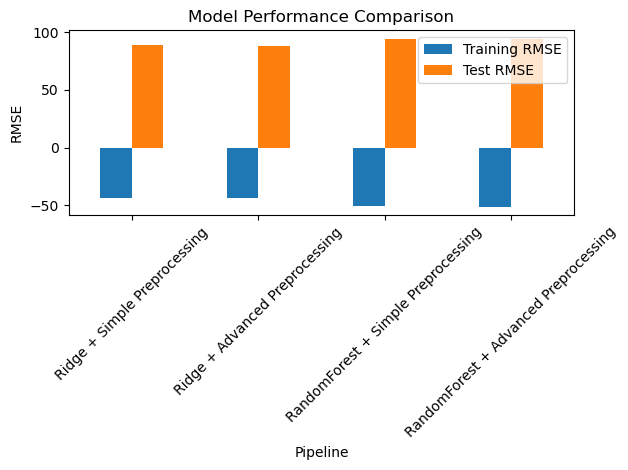


Best performing model: Ridge + Advanced Preprocessing
Best parameters: {'regressor__alpha': 0.1}
Test RMSE: 88.33630562273683


In [218]:
# Rechecking the results using a function-based approach 

# Set up all pipelines and their parameter grids
pipelines = {
    'Ridge + Simple Preprocessing': (baseline_pipe1, {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
    }),
    'Ridge + Advanced Preprocessing': (baseline_pipe2, {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
    }),
    'RandomForest + Simple Preprocessing': (advanced_pipe1, {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5]
    }),
    'RandomForest + Advanced Preprocessing': (advanced_pipe2, {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5]
    })
}

# Dictionary to store results
results_test = {}

# Train and evaluate each pipeline
for name, (pipeline, param_grid) in pipelines.items():
    print(f"\nTraining {name}...")
    
    # Train with grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=5,
        verbose=1
    )
    
    grid_search.fit(X_train, Y_train)
    
    # Store results
    results_test[name] = {
        'best_params': grid_search.best_params_,
        'best_rmse': -grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }
    
    # Calculate test score
    test_rmse = np.sqrt(mean_squared_error(
        Y_test, 
        grid_search.best_estimator_.predict(X_test)
    ))
    results_test[name]['test_rmse'] = test_rmse

# Create comparison table
comparison_df = pd.DataFrame({
    'Training RMSE': [res['best_rmse'] for res in results_test.values()],
    'Test RMSE': [res['test_rmse'] for res in results_test.values()],
}, index=results_test.keys())

# Display results
print("\nModel Comparison:")
print(comparison_df)

# Visualize results
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xlabel('Pipeline')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find best performing model
best_model_name = min(results_test.items(), key=lambda x: x[1]['test_rmse'])[0]
print(f"\nBest performing model: {best_model_name}")
print("Best parameters:", results_test[best_model_name]['best_params'])
print("Test RMSE:", results_test[best_model_name]['test_rmse'])

# # Optional: Save best model
# import pickle
# best_model = results_test[best_model_name]['best_model']
# with open('best_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)

# Evaluate

+ Which model has the best performance?

The model with the best performance is the Ridge + Advanced Preprocessing 

with the following parameters: 
{'regressor__alpha': 0.1}

# Export

+ Save the best performing model to a pickle file.

In [219]:
# Save best model
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)

In [220]:
with open('best_model.pkl', 'rb') as file:
    pipe = pickle.load(file)

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('regular_numeric',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('log_numeric',
                                                  Pipeline(steps=[('log',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc', 'isi']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', Ridge(alpha=0.1))])

In [221]:
baseline_pipe2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('regular_numeric',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('log_numeric',
                                                  Pipeline(steps=[('log',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc', 'isi']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

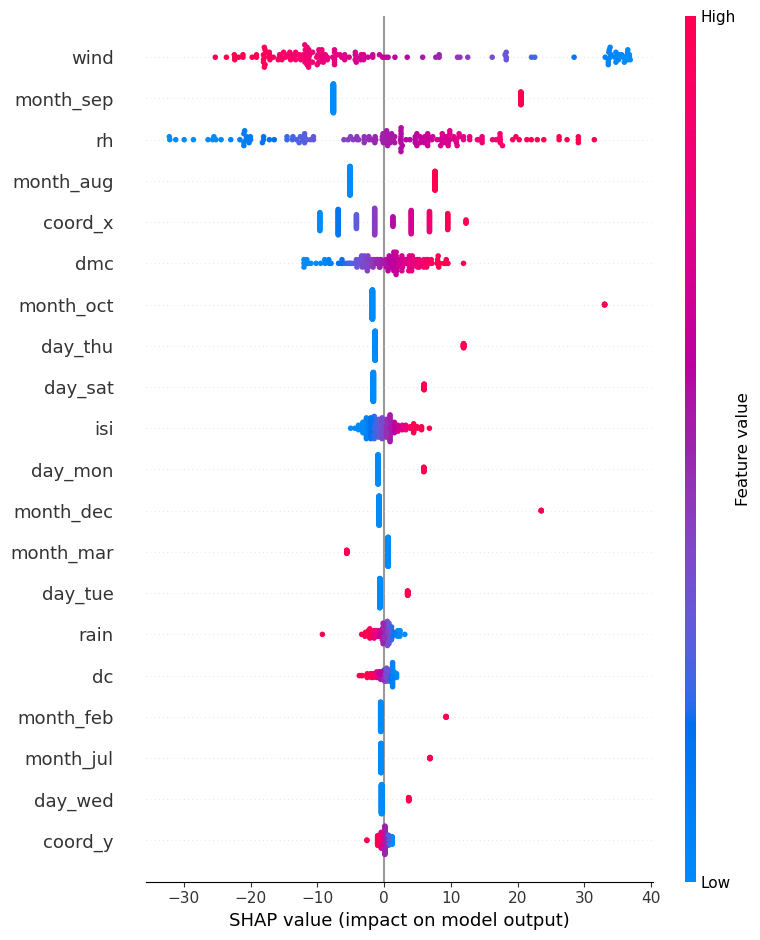

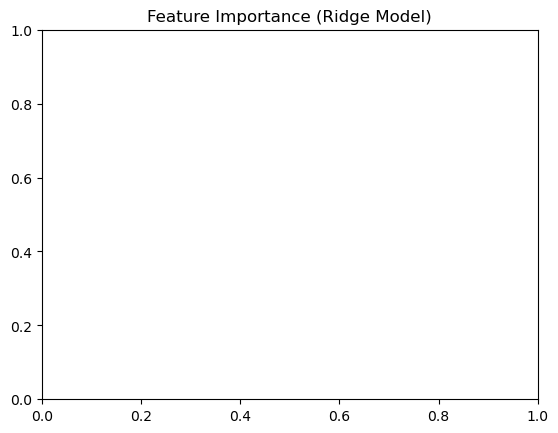

In [222]:
import shap

# Assuming we're working with Ridge model pipeline
preprocessor = pipe.named_steps['preprocessing']
ridge_model = pipe.named_steps['regressor']

# Transform the data
X_test_transformed = preprocessor.transform(X_test)

# For linear models, we need to handle the data differently
# Create a LinearExplainer
linear_explainer = shap.LinearExplainer(ridge_model, X_test_transformed)

# Get SHAP values
shap_values = linear_explainer.shap_values(X_test_transformed)

# Get feature names (same as before)
feature_names = (numerical_features + 
                list(preprocessor.named_transformers_['categorical']
                     .get_feature_names_out(categorical_features)))

# Plot global feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, 
                 feature_names=feature_names)
plt.title("Feature Importance (Ridge Model)")
plt.show()

In [223]:
shap_values

array([[ 4.07687902, -0.40471494,  0.82750949, ..., -1.32475176,
        -0.62616721, -0.36642003],
       [ 6.81303944, -0.40471494, -0.77168313, ..., -1.32475176,
         3.54828088, -0.36642003],
       [ 9.54919986, -0.94433485, -0.19015854, ..., -1.32475176,
        -0.62616721, -0.36642003],
       ...,
       [ 6.81303944, -0.94433485, -0.05931551, ..., -1.32475176,
        -0.62616721,  3.70491367],
       [ 9.54919986, -0.94433485,  0.27506113, ..., -1.32475176,
        -0.62616721, -0.36642003],
       [ 9.54919986, -0.94433485, -0.04477739, ..., -1.32475176,
        -0.62616721, -0.36642003]])

*(Answer here.)*

These are the features that can be removed: 
    month_sep    0.934067
14  month_jul    0.885314
2        ffmc    0.817284
21    day_mon    0.748742
9        rain    0.699061
25    day_tue    0.488416
24    day_thu    0.337318
23    day_sun    0.309830
26    day_wed    0.208670
17  month_may    0.169086
10  month_aug    0.142470
16  month_mar    0.113105
12  month_feb    0.078604
11  month_dec    0.054277
19  month_oct    0.047757
15  month_jun    0.020171
6        temp    0.004758
13  month_jan    0.002067
18  month_nov    0.000000

Testing Feature Importance:
To validate feature selection:

Compare model performance with and without low-importance features
If RMSE doesn't significantly worsen, we can safely remove these features
This leads to a simpler, more interpretable model

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.